# MovieRecommender

### A ai-based movie recommendation system trained with MovieLens dataset


## The dataset - a brief description

To train a neural network, which should be able to recommend you good movies based on your rating-history, a large-scale dataset is needed. Therefore the [MovieLens 100K](https://grouplens.org/datasets/movielens/100k/) dataset is used. It contains:
- 100.000 Ratings, each rating contains a one-to-five-star rating made by one user (with userID XY) on one movie (with userID YZ).
- 943 Users, labeled with an userID, age, gender, occupation and zip-code
- 1682 Movies, labeled with an movieID, title, release dates, IMDb URL and a list of genres

You can find the full documentation of the dataset structure under ML_100_INFO.md


### Acknowledgement

The dataset was published here:
F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets:
History and Context. ACM Transactions on Interactive Intelligent
Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages.
DOI=http://dx.doi.org/10.1145/2827872


### Importing data

First the data musst be imported in a usable dataformat to do some pre-processing. Also some analyzation can be done to get a feeling for the dataset, its content, diversity and limitations.
To access the data its useful to define some classes: (LEARNING: Better just use pandas_df...)

In [44]:
import DataClasses

Then its time to start importing the dataset (and required modules)

In [24]:
#Module Imports
import pandas as pd
import csv
from pathlib import Path
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
#Dataset import
IMPORT_ONLINE = False


data_dir = Path("ml-100k")

ratingFile = data_dir / "u.data"
df_ratings = pd.read_csv(ratingFile, delimiter='\t', encoding="latin",names=["userId","movieId","rating","t_stamp"],index_col=False)
movieFile = data_dir / "u.item"
# print(df_ratings)
df_movies = pd.read_csv(movieFile, delimiter='|', encoding="latin",names=["id","title","date","v_date","url","unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"])
# print(df_movies)
print(f"Sanity check:\nThe movie {df_movies['title'][212]} contains the genres: {[df_movies.columns[i] for i in range(len(df_movies.columns)) if df_movies.iloc[212][df_movies.columns[i]] == 1]}")
userFile = data_dir / "u.user"
df_users = pd.read_csv(userFile, delimiter='|', encoding="latin",names=["userId","age","gender","occupation","zip"])
# print(df_users)
print(f"Sanity check:\nThe user 111 ({df_users['gender'][110]} {df_users['age'][110]}) works as {df_users['occupation'][110]} - ID: {df_users['userId'][110]}")

Sanity check:
The movie Room with a View, A (1986) contains the genres: ['Drama', 'Romance']
Sanity check:
The user 111 (M 57) works as engineer - ID: 111


In [ ]:

# DataClasses.importAsDataClasses() #not used bd too complicated
if(IMPORT_ONLINE):
    print()
    #TODO: Import from url
else:
    with open(r'ml-100k\u.data') as ml_100_data: #ml-100k\u.data
        data_csv = csv.reader(ml_100_data, delimiter ='\t')
        ratings = list(data_csv)

    movies = list()
    with open(r'ml-100k\u.item') as movies_data: #ml-100k\u.data
        movies_csv = csv.reader(movies_data, delimiter ='|')
        data_dir = Path("ml-100k")
        itemFile = data_dir / "u.item"
        df_movies = pd.read_csv(itemFile)
        for row in movies_csv:
            movies.append(Movie(id=row[0], title=row[1], r_date=row[2], v_date=row[3], url=str(row[4]), g_list=row[5:24]))
    print(f"Sanity check:\nThe movie {movies[0].title} contains the genres: {movies[0].get_genres()}")

    users = list()
    with open(r'ml-100k\u.user') as users_data: #ml-100k\u.data
        users_csv = csv.reader(users_data, delimiter ='|')
        for row in users_csv:
            users.append(User(id=row[0],age=row[1],gender=row[2],occ=row[3],zip=row[4]))
    print(f"Sanity check:\nThe user 111 ({users[110].gender} {users[110].age}) works as {users[110].occupation} - ID: {users[110].id}")

### Analyzation


In [ ]:
# Analyse: Best Movie, average ratings, average rating counts,
# #TODO: plot ratings, best movie and stuff

### Preprocessing
After successfully importing all relevant data, the next step is to pre-process the data so it fits our nn-input

## The nn-architecture
### Goal
The goal of the recommender system is to predict the best movie recommendation for user with respect to his ratings on other movies and the movie-ratings of other users in general. The easiest way to determine the "best" movie is to predict the users rating on unwatched movies and pick the highest rated one.
### First approach: Genre-recommendation
The first idea to predict the users rating (before diving into collaborative filtering) was to calculate every users preferences based on his rating-history and then train classical dense neural-network with it:

``Picture``

First the genre-preference calculation has to be done. The output of it should be a weighted genre list containg values in \[0,1]
The input of the nn is defined by the count of genres: 18 movie genres + 18 preference-weighted genres

In [ ]:
#approach specific pre-processing
ratings.sort() #by time and user
#change movie id to genre or include at row[4:23]

0
0
Sanity check: User 50 has preference for genres:
             Preference
unknown        0.000000
Action         0.000000
Adventure      0.000000
Animation      0.000000
Children's     0.000000
Comedy         0.075000
Crime          0.133333
Documentary    0.041667
Drama          0.458333
Fantasy        0.000000
Film-Noir      0.025000
Horror         0.066667
Musical        0.041667
Mystery        0.075000
Romance        0.225000
Sci-Fi         0.000000
Thriller       0.083333
War            0.016667
Western        0.000000


<AxesSubplot: >

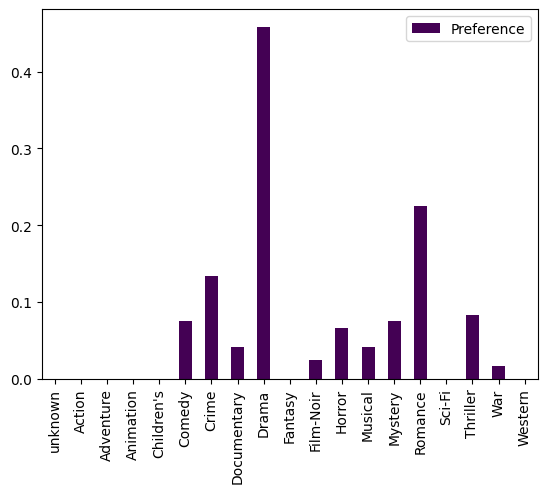

In [66]:
#User genre preference calculation based on all other ratings in the training set
def calc_pref(userID, movieID, count=0):
    #get all ratings:
    user_ratings = df_ratings.loc[(df_ratings["userId"] == userID) & (df_ratings["movieId"] != movieID)]
    user_movies = df_movies.loc[df_movies["id"].isin(user_ratings["movieId"])]

    # add rating in correct order
    user_rating_sorted = [int(user_ratings.loc[(user_ratings["movieId"]==id),"rating"]) for id  in user_movies["id"]]
    genre_table = user_movies.loc[:,"unknown":"Western"]# #only genres
    num_movies = len(user_movies)
    if num_movies:
        g_mat = genre_table.to_numpy()
        r_mat = np.asarray(user_rating_sorted)
        r_mat = np.tile(r_mat, (19,1))
        g_mat = g_mat * r_mat.transpose() / 5 #weight g_mat with rating
        pref_mat = np.asarray([np.sum(g_mat[:,i]) for i in range(np.shape(g_mat)[1])])
        pref_mat = pref_mat / num_movies #normalize to num_movies
        print(count)
        # multiply with rating
        return pref_mat
    else:
        return 0

res = calc_pref(12,23)
df_test = pd.DataFrame(calc_pref(50,101),index= df_movies.columns[5:24].values,columns=["Preference"])
print(f"Sanity check: User 50 has preference for genres:\n{df_test}")
df_test.plot(kind='bar',colormap = mpl.colormaps['viridis'])

In [69]:
#Dataset preparation:
# x_test and x_train:
num_samples = len(df_ratings)

# [user_preferences movie_genres]
x1 = [[calc_pref(df_ratings.loc[i,"userId"],df_ratings.loc[i,"movieId"] ,i).tolist(), df_movies.loc[df_ratings.loc[i,"movieId"]-1, "unknown":"Western"].values.tolist()] for i in range(2000)]

y = [df_ratings.iloc[i,2] for i in range(2000)]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [50]:
print(x, y)

[[[0.0, 0.02631578947368421, 0.05263157894736842, 0.0, 0.042105263157894736, 0.5842105263157896, 0.0, 0.021052631578947368, 0.23684210526315788, 0.021052631578947368, 0.0, 0.0, 0.0, 0.0, 0.20526315789473684, 0.03157894736842106, 0.0, 0.031578947368421054, 0.0], [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]], [[0.0, 0.23516483516483516, 0.0989010989010989, 0.03956043956043956, 0.07472527472527471, 0.08571428571428572, 0.07472527472527472, 0.0, 0.1956043956043956, 0.01098901098901099, 0.01098901098901099, 0.004395604395604396, 0.035164835164835165, 0.07692307692307693, 0.052747252747252754, 0.046153846153846156, 0.39560439560439553, 0.013186813186813189, 0.030769230769230767], [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0.0, 0.3921259842519685, 0.19055118110236222, 0.0, 0.014173228346456693, 0.33700787401574817, 0.05039370078740158, 0.0, 0.11181102362204724, 0.0015748031496062994, 0.007874015748031496, 0.029921259842519685, 0.02677165354330709, 0.00472440944

## Setting up the nn model:

In [28]:
# Network to estimate user rating based on genre preferences:
rater = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='relu'),
])

rater.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


## Training

In [ ]:
rater.fit(
    x_train, #TODO
    y_train,
    epochs=10,
    batch_size=8,
    validation_data=(x_test, y_test)
)

# Findings and outlook